[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/19ks_y6RxHxslzdqtH4AkL3mAbJ4m2eOx#scrollTo=wzvqt7TlnK-Y)

### Amazon.com - Employee Access Challenge

**[1. Data loading and overview](#heading--1)**

**[2. Exploratory Data Analysis](#heading--2)**

  * [2.1. Checking duplicates](#heading--2-1)
  * [2.2. Checking missing values](#heading--2-2)
  * [2.3. Outliers detection](#heading--2-3)
  * [2.4. Target variable ACTION](#heading--2-4)
  * [2.5. The other columns](#heading--2-5)

**[3. Data Preprocessing](#heading--3)**

  * [3.1. Correlation with ACTION](#heading--3-1)
  * [3.2. Adding new features](#heading--3-2)
  * [3.3. Data Transformation](#heading--3-3)
  * [3.4. Random oversampling imbalanced dataset](#heading--3-4)
  
**[4. Model Training and prediction](#heading--4)**

  * [4.1. Initializing the models](#heading--4-1)
  * [4.2. K-nearest Neighbour](#heading--4-2)
  * [4.3. Support Vector Machine (SVM)](#heading--4-3)
  * [4.4. Logistic regression](#heading--4-4)
  * [4.5. Decision Tree](#heading--4-5)
  * [4.6. Random Forest](#heading--4-6)
  * [4.7. XGBoost classification](#heading--4-7)
  * [4.8. Comparison of results](#heading--4-8)






  
  
  

In [109]:
# Data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline 
style.use('ggplot')
sns.set()

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Machine learning libraries:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_auc_score, accuracy_score, f1_score)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


### 1. Data loading and overview <a name="heading--1"/>

In [110]:
# Loading train and test data
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')

# copying of original data
train = train_raw.copy()
test = test_raw.copy()

# Id from test set is necessary to submit the file on Kaggle
test_id = test.pop('id')


In [111]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [112]:
test.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [114]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   RESOURCE          58921 non-null  int64
 1   MGR_ID            58921 non-null  int64
 2   ROLE_ROLLUP_1     58921 non-null  int64
 3   ROLE_ROLLUP_2     58921 non-null  int64
 4   ROLE_DEPTNAME     58921 non-null  int64
 5   ROLE_TITLE        58921 non-null  int64
 6   ROLE_FAMILY_DESC  58921 non-null  int64
 7   ROLE_FAMILY       58921 non-null  int64
 8   ROLE_CODE         58921 non-null  int64
dtypes: int64(9)
memory usage: 4.0 MB


In [115]:
# some basic statistics for numerical columns
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ACTION,32769.0,0.942110,0.233539,0.0,1.0,1.0,1.0,1.0
RESOURCE,32769.0,42923.916171,34173.892702,0.0,20299.0,35376.0,74189.0,312153.0
MGR_ID,32769.0,25988.957979,35928.031650,25.0,4566.0,13545.0,42034.0,311696.0
ROLE_ROLLUP_1,32769.0,116952.627788,10875.563591,4292.0,117961.0,117961.0,117961.0,311178.0
ROLE_ROLLUP_2,32769.0,118301.823156,4551.588572,23779.0,118102.0,118300.0,118386.0,286791.0
ROLE_DEPTNAME,32769.0,118912.779914,18961.322917,4674.0,118395.0,118921.0,120535.0,286792.0
ROLE_TITLE,32769.0,125916.152644,31036.465825,117879.0,118274.0,118568.0,120006.0,311867.0
ROLE_FAMILY_DESC,32769.0,170178.369648,69509.462130,4673.0,117906.0,128696.0,235280.0,311867.0
ROLE_FAMILY,32769.0,183703.408893,100488.407413,3130.0,118363.0,119006.0,290919.0,308574.0
ROLE_CODE,32769.0,119789.430132,5784.275516,117880.0,118232.0,118570.0,119348.0,270691.0


In [116]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
RESOURCE,58921.0,39383.739482,33717.397122,0.0,18418.0,33248.0,45481.0,312136.0
MGR_ID,58921.0,26691.645050,35110.244281,25.0,4663.0,14789.0,46512.0,311779.0
ROLE_ROLLUP_1,58921.0,117028.638041,10805.446548,4292.0,117961.0,117961.0,117961.0,311178.0
ROLE_ROLLUP_2,58921.0,118316.334091,4284.678750,23779.0,118096.0,118300.0,118386.0,194897.0
ROLE_DEPTNAME,58921.0,118858.006721,17916.179109,4674.0,118378.0,118910.0,120410.0,277693.0
ROLE_TITLE,58921.0,126358.019993,32068.294507,117879.0,118259.0,118636.0,120006.0,311867.0
ROLE_FAMILY_DESC,58921.0,170455.861425,69684.692799,4673.0,117913.0,129282.0,234813.0,311867.0
ROLE_FAMILY,58921.0,179278.058960,99639.965300,3130.0,118331.0,118704.0,290919.0,308574.0
ROLE_CODE,58921.0,119707.754264,5326.979178,117880.0,118055.0,118570.0,119353.0,270691.0


In [117]:
print(f'the shape of the train set: {train.shape}')
print(f'the shape of the test set: {test.shape}')

the shape of the train set: (32769, 10)
the shape of the test set: (58921, 9)


### 2. Exploratory Data Analysis <a name="heading--2"/>

**Column Descriptions:**

ACTION: ACTION is 1 if the resource was approved, 0 if the resource was not.

RESOURCE: An ID for each resource.

MGR_ID: The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time.

ROLE_ROLLUP_1: Company role grouping category id 1 (e.g. US Engineering).

ROLE_ROLLUP_2: Company role grouping category id 2 (e.g. US Retail).

ROLE_DEPTNAME: Company role department description (e.g. Retail).

ROLE_TITLE: Company role business title description (e.g. Senior Engineering Retail Manager).

ROLE_FAMILY_DESC: Company role family extended description (e.g. Retail Manager, Software Engineering).

ROLE_FAMILY: Company role family description (e.g. Retail Manager).

ROLE_CODE: Company role code; this code is unique to each role (e.g. Manager).

#### 2.1. Checking duplicates <a name="heading--2-1"/>

Checking if there are duplicate rows in training and test sets

In [118]:
train.duplicated().sum()

0

In [119]:
test.duplicated().sum()

0

#### 2.2. Checking missing values <a name="heading--2-2"/>

Checking if there are null values in training and test sets

In [120]:
train.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [121]:
test.isnull().sum()

RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

#### 2.3. Outliers detection <a name="heading--2-3"/>


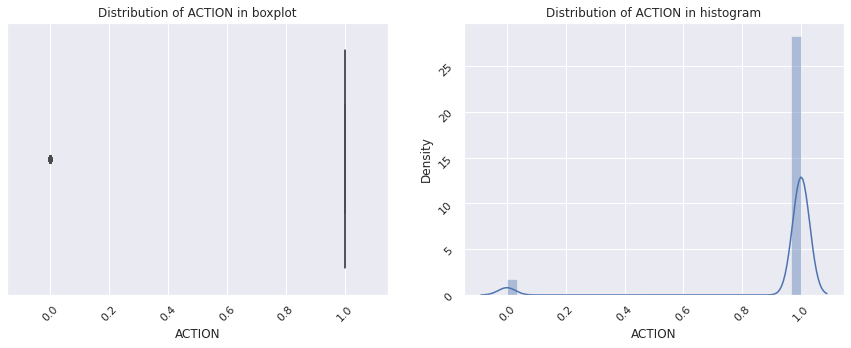

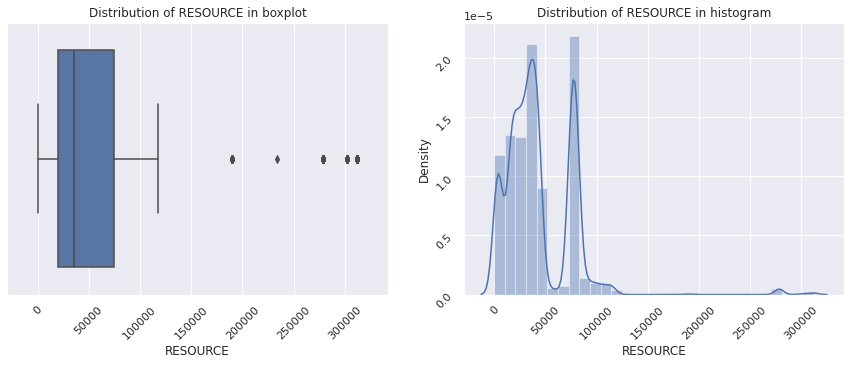

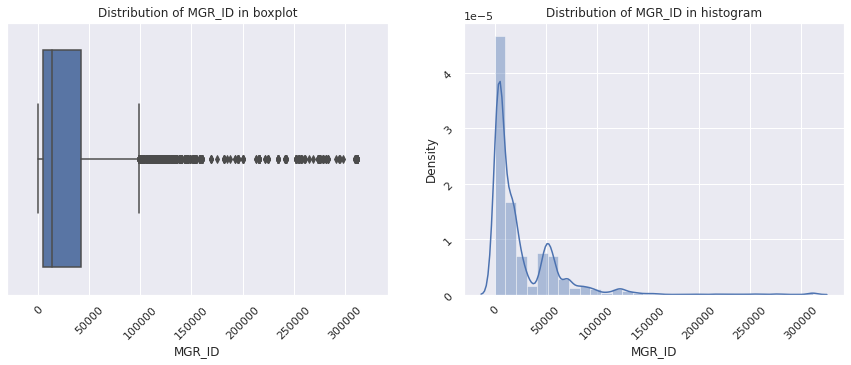

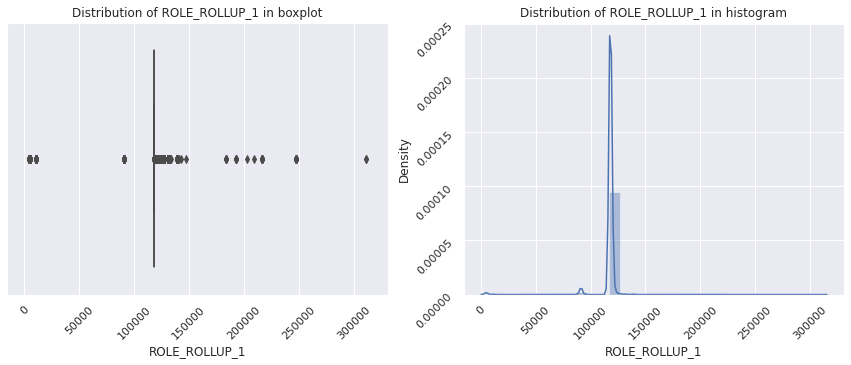

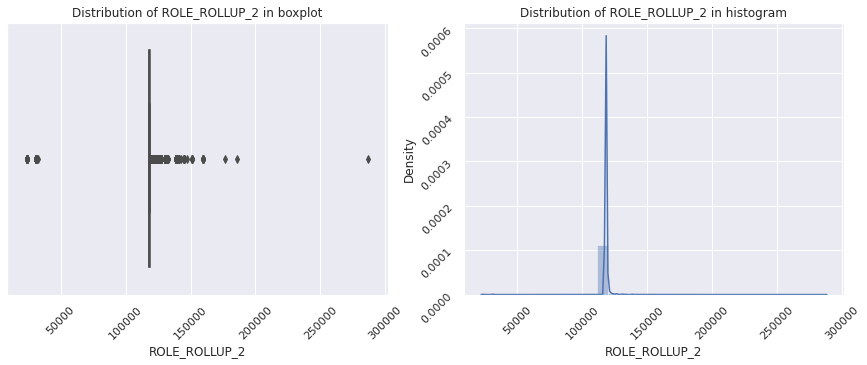

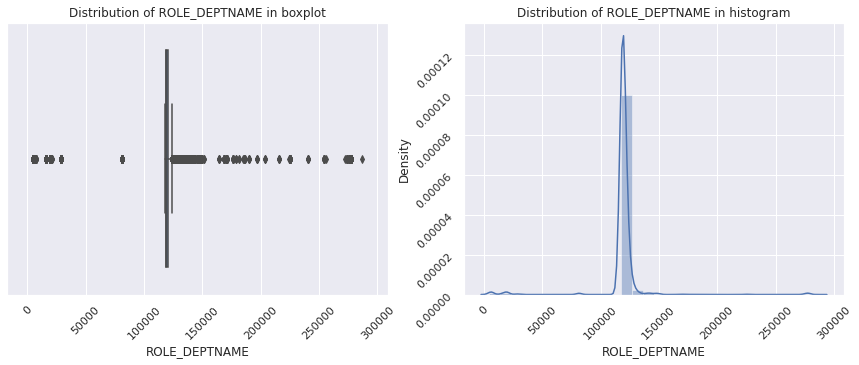

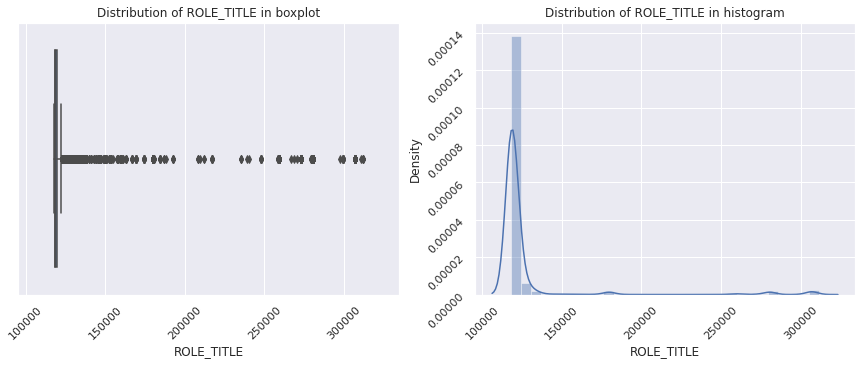

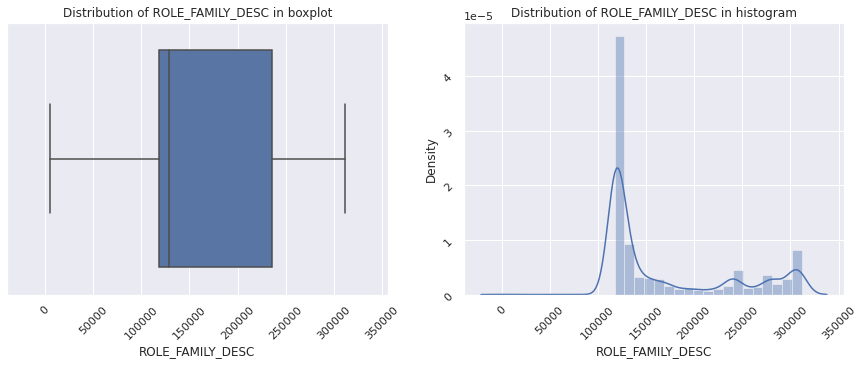

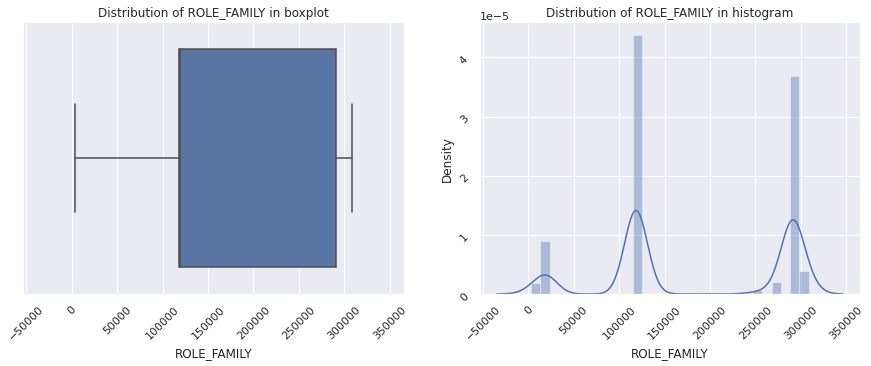

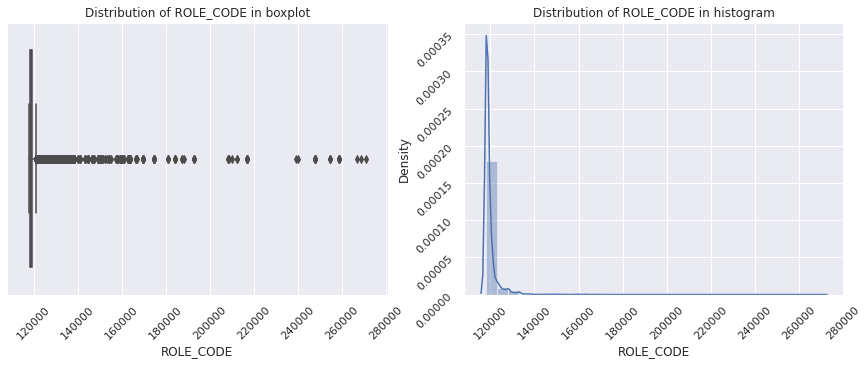

In [122]:
# Plots for detecting outliers

for i in train.columns:
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15, 5)) 

    sns.boxplot(train[i].dropna(), ax=ax[0])
    sns.distplot(train[i], bins=30, ax=ax[1])

    ax[0].title.set_text(f'Distribution of {i} in boxplot')
    ax[0].tick_params(labelrotation=45)
    ax[1].title.set_text(f'Distribution of {i} in histogram')
    ax[1].tick_params(labelrotation=45)
    plt.show()
    print()


IQR method

IQR method identifies outliers to set up a “fence” outside of Q1 and Q3. Any values that fall outside of this fence are considered outliers. To build this fence we take 1.5 times the IQR and then subtract this value from Q1 and add this value to Q3

* Q1 represents the 1st quartile/25th percentile of the data.
* Q2 represents the 2nd quartile/median/50th percentile of the data.
* Q3 represents the 3rd quartile/75th percentile of the data.
* (Q1–1.5$\cdot$IQR) represent the smallest value in the data set and (Q3+1.5$\cdot$IQR) represnt the largest value in the data set.

In [123]:
def iqr_outliers(df):
    out=[]
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            out.append(i)
    print(f"10 examples of outliers in {df.name}:", out[:10])
    print(f"In {df.name} there are {len(out)} outliers of {len(df)} values'\n")
    
# checking outliers and its numbers for each column without target variable ACTION
for col in train.columns[1:]:
    iqr_outliers(train[col])

10 examples of outliers in RESOURCE: [278393, 302049, 278393, 278393, 278393, 278393, 302049, 278393, 312089, 278393]
In RESOURCE there are 245 outliers of 32769 values'

10 examples of outliers in MGR_ID: [111936, 169112, 273476, 225257, 98689, 111936, 124899, 120822, 139593, 273476]
In MGR_ID there are 1223 outliers of 32769 values'

10 examples of outliers in ROLE_ROLLUP_1: [118219, 117929, 117951, 118079, 117902, 118315, 91261, 118219, 118315, 118216]
In ROLE_ROLLUP_1 there are 11362 outliers of 32769 values'

10 examples of outliers in ROLE_ROLLUP_2: [119070, 119135, 119070, 121786, 120343, 119091, 118888, 119256, 121013, 119597]
In ROLE_ROLLUP_2 there are 3215 outliers of 32769 values'

10 examples of outliers in ROLE_DEPTNAME: [6725, 127522, 123901, 124725, 132530, 225010, 126310, 277693, 124921, 128823]
In ROLE_DEPTNAME there are 3249 outliers of 32769 values'

10 examples of outliers in ROLE_TITLE: [126820, 128230, 179731, 280788, 307024, 125171, 307024, 128903, 179731, 127782

There are no values but only id's or some descriptions so it is no needed to dealing with outliers

#### 2.4. Target variable ACTION <a name="heading--2-4"/>

ACTION is 1 if the resource was approved, 0 if the resource was not.

In [124]:
train['ACTION'].head()

0    1
1    1
2    1
3    1
4    1
Name: ACTION, dtype: int64

In [125]:
train['ACTION'].value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

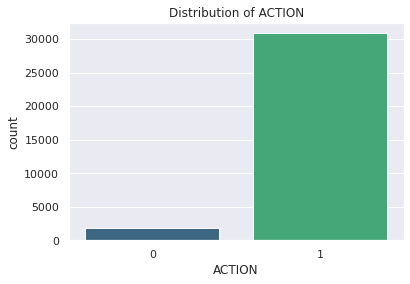

In [126]:
sns.countplot(train['ACTION'], palette="viridis")
plt.title('Distribution of ACTION')
plt.show()

The ACTION dataset is imbalanced. The 1 label has more values.

#### 2.5. The other columns <a name="heading--2-5"/>



- RESOURCE:

First 5 samples of RESOURCE: 
0    39353
1    17183
2    36724
3    36135
4    42680
Name: RESOURCE, dtype: int64


In column RESOURCE there are 7518 unique values: 
4675     839
79092    484
25993    409
75078    409
3853     404
        ... 
35014      1
75535      1
30936      1
89856      1
16376      1
Name: RESOURCE, Length: 7518, dtype: int64

The 20 most common values in RESOURCE - plot


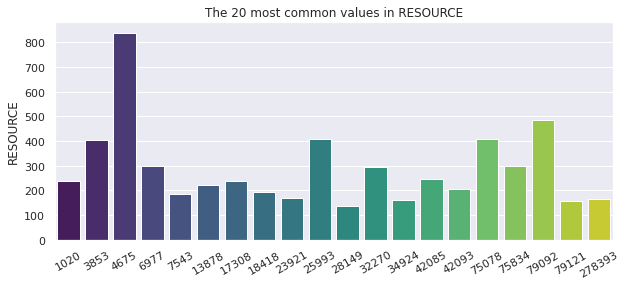


Relationship between target variable ACTION and RESOURCE - plot


<Figure size 648x432 with 0 Axes>

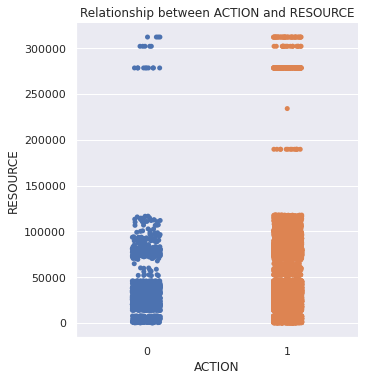


- MGR_ID:

First 5 samples of MGR_ID: 
0    85475
1     1540
2    14457
3     5396
4     5905
Name: MGR_ID, dtype: int64


In column MGR_ID there are 4243 unique values: 
770      152
2270      99
2594      82
1350      71
2014      67
        ... 
1940       1
8087       1
22526      1
34948      1
58677      1
Name: MGR_ID, Length: 4243, dtype: int64

The 20 most common values in MGR_ID - plot


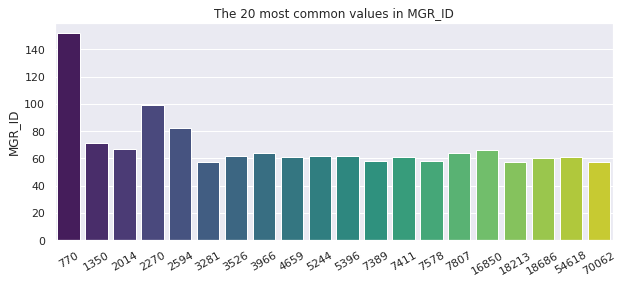


Relationship between target variable ACTION and MGR_ID - plot


<Figure size 648x432 with 0 Axes>

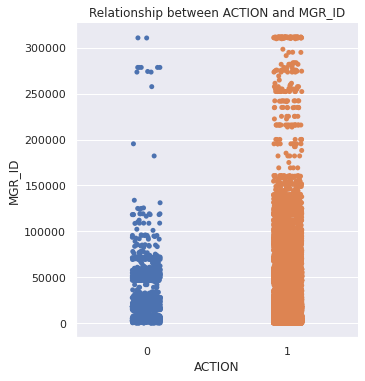


- ROLE_ROLLUP_1:

First 5 samples of ROLE_ROLLUP_1: 
0    117961
1    117961
2    118219
3    117961
4    117929
Name: ROLE_ROLLUP_1, dtype: int64


In column ROLE_ROLLUP_1 there are 128 unique values: 
117961    21407
117902      742
91261       721
118315      498
118212      400
          ...  
203209        1
209434        1
141221        1
119343        1
121411        1
Name: ROLE_ROLLUP_1, Length: 128, dtype: int64

The 20 most common values in ROLE_ROLLUP_1 - plot


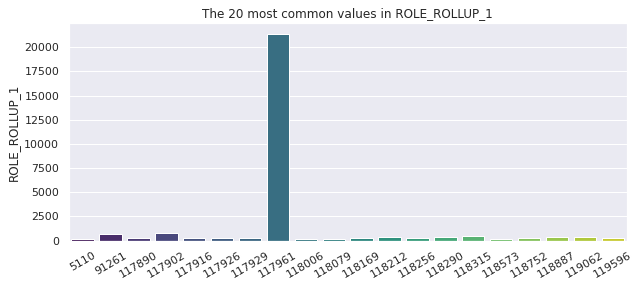


Relationship between target variable ACTION and ROLE_ROLLUP_1 - plot


<Figure size 648x432 with 0 Axes>

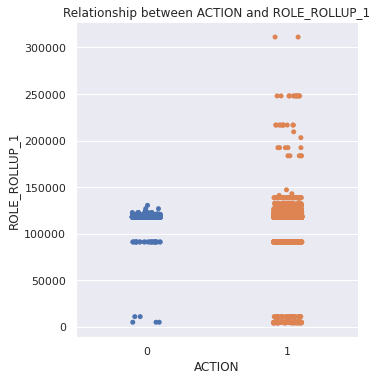


- ROLE_ROLLUP_2:

First 5 samples of ROLE_ROLLUP_2: 
0    118300
1    118343
2    118220
3    118343
4    117930
Name: ROLE_ROLLUP_2, dtype: int64


In column ROLE_ROLLUP_2 there are 177 unique values: 
118300    4424
118343    3945
118327    2641
118225    2547
118386    1796
          ... 
141222       1
32137        1
120355       1
118775       1
120018       1
Name: ROLE_ROLLUP_2, Length: 177, dtype: int64

The 20 most common values in ROLE_ROLLUP_2 - plot


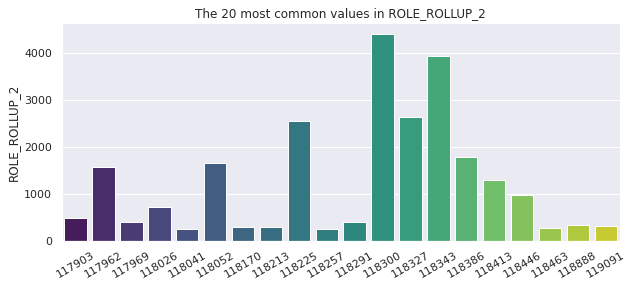


Relationship between target variable ACTION and ROLE_ROLLUP_2 - plot


<Figure size 648x432 with 0 Axes>

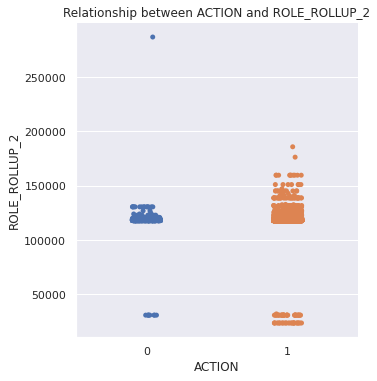


- ROLE_DEPTNAME:

First 5 samples of ROLE_DEPTNAME: 
0    123472
1    123125
2    117884
3    119993
4    119569
Name: ROLE_DEPTNAME, dtype: int64


In column ROLE_DEPTNAME there are 449 unique values: 
117878    1135
117941     763
117945     659
118514     601
117920     597
          ... 
123175       1
122963       1
123675       1
119565       1
272283       1
Name: ROLE_DEPTNAME, Length: 449, dtype: int64

The 20 most common values in ROLE_DEPTNAME - plot


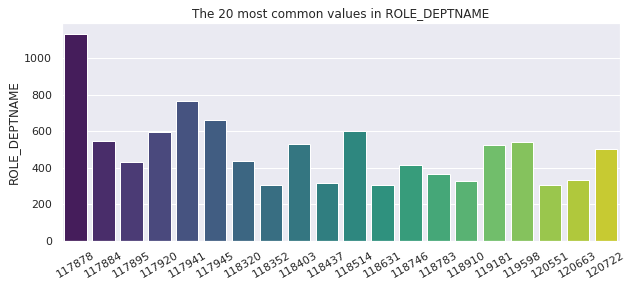


Relationship between target variable ACTION and ROLE_DEPTNAME - plot


<Figure size 648x432 with 0 Axes>

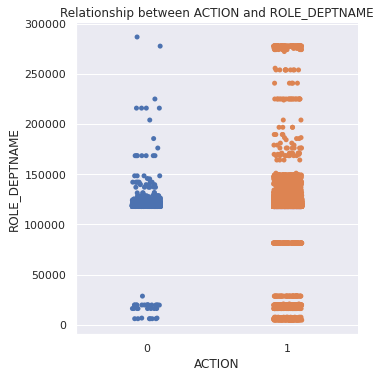


- ROLE_TITLE:

First 5 samples of ROLE_TITLE: 
0    117905
1    118536
2    117879
3    118321
4    119323
Name: ROLE_TITLE, dtype: int64


In column ROLE_TITLE there are 343 unique values: 
118321    4649
117905    3583
118784    1772
117879    1256
118568    1043
          ... 
126931       1
239003       1
130362       1
157347       1
125405       1
Name: ROLE_TITLE, Length: 343, dtype: int64

The 20 most common values in ROLE_TITLE - plot


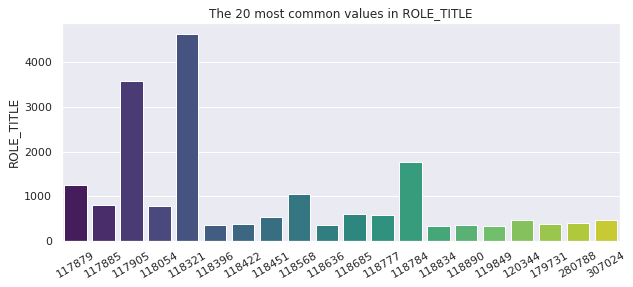


Relationship between target variable ACTION and ROLE_TITLE - plot


<Figure size 648x432 with 0 Axes>

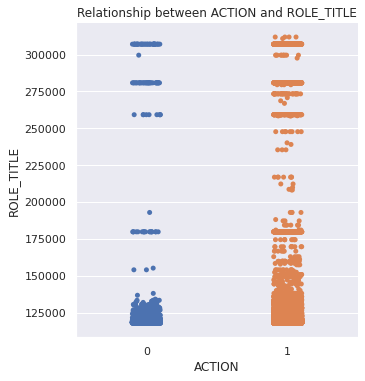


- ROLE_FAMILY_DESC:

First 5 samples of ROLE_FAMILY_DESC: 
0    117906
1    118536
2    267952
3    240983
4    123932
Name: ROLE_FAMILY_DESC, dtype: int64


In column ROLE_FAMILY_DESC there are 2358 unique values: 
117906    6896
240983    1244
117913     670
279443     665
117886     530
          ... 
125925       1
130023       1
160903       1
128102       1
157709       1
Name: ROLE_FAMILY_DESC, Length: 2358, dtype: int64

The 20 most common values in ROLE_FAMILY_DESC - plot


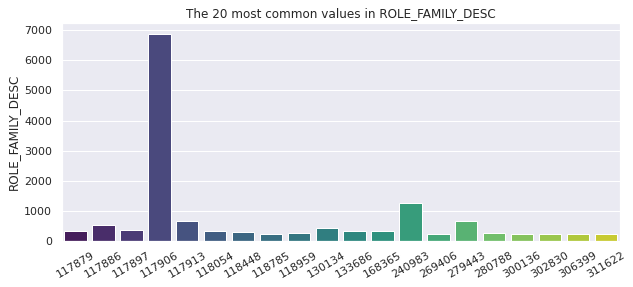


Relationship between target variable ACTION and ROLE_FAMILY_DESC - plot


<Figure size 648x432 with 0 Axes>

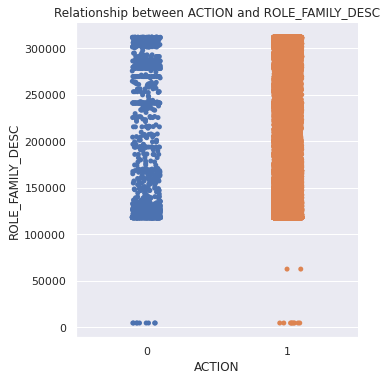


- ROLE_FAMILY:

First 5 samples of ROLE_FAMILY: 
0    290919
1    308574
2     19721
3    290919
4     19793
Name: ROLE_FAMILY, dtype: int64


In column ROLE_FAMILY there are 67 unique values: 
290919    10980
118424     2690
19721      2636
117887     2400
292795     1318
          ...  
130364        3
159679        3
161100        2
149353        2
132725        2
Name: ROLE_FAMILY, Length: 67, dtype: int64

The 20 most common values in ROLE_FAMILY - plot


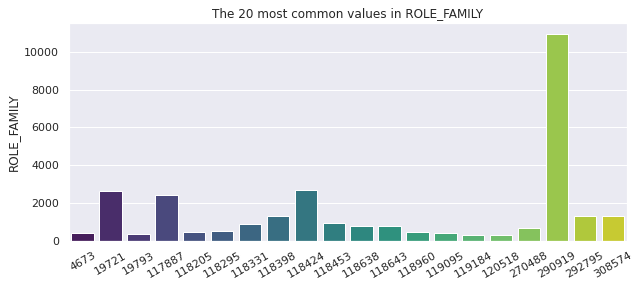


Relationship between target variable ACTION and ROLE_FAMILY - plot


<Figure size 648x432 with 0 Axes>

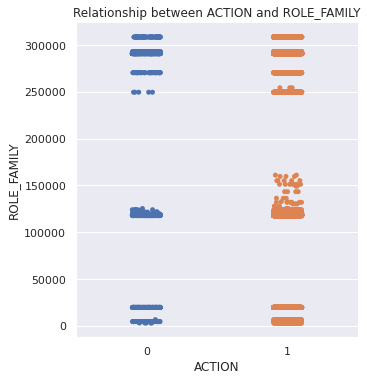


- ROLE_CODE:

First 5 samples of ROLE_CODE: 
0    117908
1    118539
2    117880
3    118322
4    119325
Name: ROLE_CODE, dtype: int64


In column ROLE_CODE there are 343 unique values: 
118322    4649
117908    3583
118786    1772
117880    1256
118570    1043
          ... 
266863       1
126504       1
239004       1
126549       1
188048       1
Name: ROLE_CODE, Length: 343, dtype: int64

The 20 most common values in ROLE_CODE - plot


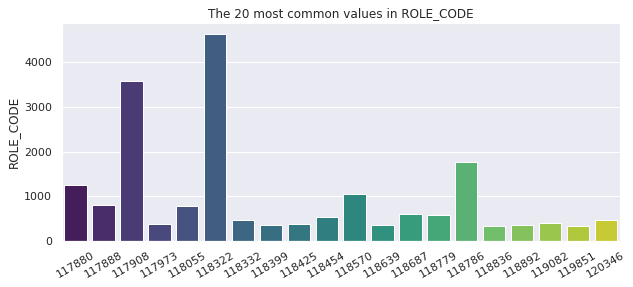


Relationship between target variable ACTION and ROLE_CODE - plot


<Figure size 648x432 with 0 Axes>

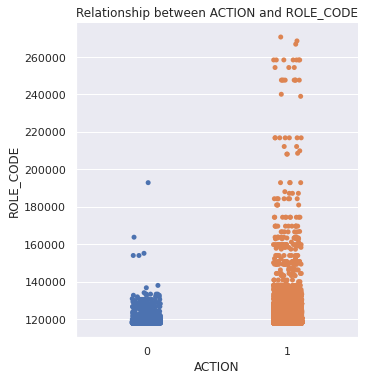

In [127]:
for col in train.columns[1:]:
    print(f'\n- {col}:')
    print(f"\nFirst 5 samples of {col}: \n{train[col].head()}\n")
    print(f"\nIn column {col} there are {train[col].nunique()} unique values: \n{train[col].value_counts()}\n")
    print(f'The 20 most common values in {col} - plot')
    plt.figure(figsize=(10,4))
    sns.barplot(x=train[col].value_counts()[:20].index,
               y=train[col].value_counts()[:20],
                palette="viridis").set_title(f'The 20 most common values in {col}')
    plt.xticks(rotation=30)
    plt.show()
    print(f'\nRelationship between target variable ACTION and {col} - plot')
    plt.figure(figsize=(9, 6))
    sns.catplot('ACTION', col, data=train)
    plt.title(f'Relationship between ACTION and {col}')
    plt.show()

### 3. Data Preprocessing <a name="heading--3"/>

#### 3.1. Correlation with ACTION <a name="heading--3-1"/>

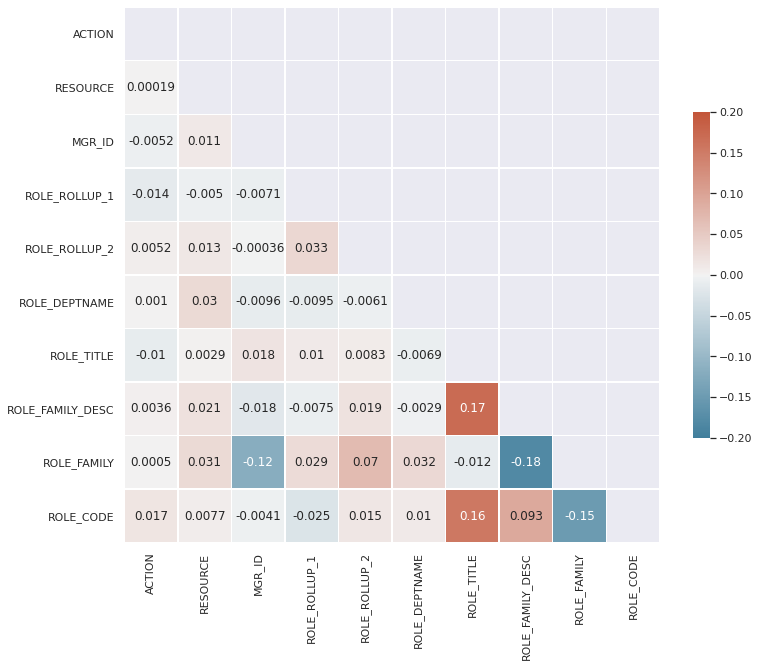

In [128]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(train.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(train.corr(), annot=True, mask=mask, cmap=cmap, vmax=0.2, center=0, vmin=-0.2, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [129]:
train.corr()['ACTION'].sort_values(ascending=False)[1:]

ROLE_CODE           0.017147
ROLE_ROLLUP_2       0.005179
ROLE_FAMILY_DESC    0.003565
ROLE_DEPTNAME       0.001025
ROLE_FAMILY         0.000502
RESOURCE            0.000185
MGR_ID             -0.005167
ROLE_TITLE         -0.010169
ROLE_ROLLUP_1      -0.013702
Name: ACTION, dtype: float64

Target variable 'ACTION' is not strongly correlated with any attribute

#### 3.2. Adding new features <a name="heading--3-2"/>

In point 2.5 we can see that in columns ROLE_ROLLUP_1, ROLE_ROLLUP_2 and in ROLE_CODE over some level there are only 1 for ACTION so we can generete new features for these 3 columns describing if that columns are bigger than that level

In [130]:
# checking the maximum values of "ROLE_ROLLUP_1" provided that "ACTION" is 0
train['ROLE_ROLLUP_1'][(train['ACTION'] == 0) & (train['ROLE_ROLLUP_1'] > 130000)]

6395    130570
Name: ROLE_ROLLUP_1, dtype: int64

In [131]:
train['is_ROLE_ROLLUP_1_bigger_than_140000'] = np.where(train['ROLE_ROLLUP_1'] > 140000, 1, 0)
test['is_ROLE_ROLLUP_1_bigger_than_140000'] = np.where(test['ROLE_ROLLUP_1'] > 140000, 1, 0)

In [132]:
# checking the maximum values of "ROLE_ROLLUP_2" provided that "ACTION" is 0
train['ROLE_ROLLUP_2'][(train['ACTION'] == 0) & (train['ROLE_ROLLUP_2'] > 130000)]

1488     130600
4406     286791
5915     130600
6170     130600
6520     130600
10858    130600
15413    130600
18418    130600
20274    130600
21144    130600
22628    130600
23479    130600
27442    130600
28157    130600
31225    130600
Name: ROLE_ROLLUP_2, dtype: int64

In [133]:
train['is_ROLE_ROLLUP_2_bigger_than_140000'] = np.where(train['ROLE_ROLLUP_2'] > 140000, 1, 0)
test['is_ROLE_ROLLUP_2_bigger_than_140000'] = np.where(test['ROLE_ROLLUP_2'] > 140000, 1, 0)

In [134]:
# checking the maximum values of "ROLE_CODE" provided that "ACTION" is 0
train['ROLE_CODE'][(train['ACTION'] == 0) & (train['ROLE_CODE'] > 190000)]

11936    192869
Name: ROLE_CODE, dtype: int64

In [135]:
train['is_ROLE_CODE_bigger_than_200000'] = np.where(train['ROLE_CODE'] > 200000, 1, 0)
test['is_ROLE_CODE_bigger_than_200000'] = np.where(test['ROLE_CODE'] > 200000, 1, 0)

In [136]:
# checking the distribution of new columns
for i in train[['is_ROLE_ROLLUP_1_bigger_than_140000', 
                'is_ROLE_ROLLUP_2_bigger_than_140000', 
                'is_ROLE_CODE_bigger_than_200000']]:
    print(f'- values in column \'{i}\':\n{train[i].value_counts()}\n\n')

- values in column 'is_ROLE_ROLLUP_1_bigger_than_140000':
0    32730
1       39
Name: is_ROLE_ROLLUP_1_bigger_than_140000, dtype: int64


- values in column 'is_ROLE_ROLLUP_2_bigger_than_140000':
0    32729
1       40
Name: is_ROLE_ROLLUP_2_bigger_than_140000, dtype: int64


- values in column 'is_ROLE_CODE_bigger_than_200000':
0    32733
1       36
Name: is_ROLE_CODE_bigger_than_200000, dtype: int64




In [137]:
# Checking if there in train columns still are null values
train.isnull().sum()

ACTION                                 0
RESOURCE                               0
MGR_ID                                 0
ROLE_ROLLUP_1                          0
ROLE_ROLLUP_2                          0
ROLE_DEPTNAME                          0
ROLE_TITLE                             0
ROLE_FAMILY_DESC                       0
ROLE_FAMILY                            0
ROLE_CODE                              0
is_ROLE_ROLLUP_1_bigger_than_140000    0
is_ROLE_ROLLUP_2_bigger_than_140000    0
is_ROLE_CODE_bigger_than_200000        0
dtype: int64

In [138]:
# Checking if there in test columns still are null values
test.isnull().sum()

RESOURCE                               0
MGR_ID                                 0
ROLE_ROLLUP_1                          0
ROLE_ROLLUP_2                          0
ROLE_DEPTNAME                          0
ROLE_TITLE                             0
ROLE_FAMILY_DESC                       0
ROLE_FAMILY                            0
ROLE_CODE                              0
is_ROLE_ROLLUP_1_bigger_than_140000    0
is_ROLE_ROLLUP_2_bigger_than_140000    0
is_ROLE_CODE_bigger_than_200000        0
dtype: int64

#### 3.3. Data Transformation <a name="heading--3-3"/>

In [139]:
# Formating for modeling
y_train = train['ACTION']
X_train = train.drop('ACTION', axis=1)

### 4. Model Training and prediction <a name="heading--4"/>

#### 4.1. Initializing the models <a name="heading--4-1"/>

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.25, 
                                                    random_state=0)

print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_test shape {y_test.shape}')
print(f'\nTest ratio: {len(X_test) / len(train):.2f}')

X_train shape (24576, 12)
y_train shape (24576,)
X_test shape (8193, 12)
y_test shape (8193,)

Test ratio: 0.25


In [141]:
# In order to avoid any data leakage from the testing to the training set 
# the standarization is ran after splitting into train and test set
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### 4.2. K-nearest Neighbour <a name="heading--4-2"/>

In [142]:
# selecting parameters for GridSearch
param_grid = {'n_neighbors': np.arange(2, 8)}

knn = KNeighborsClassifier()

In [143]:
# using GridSearchCV to find the best parameters
grid_search_knn = GridSearchCV(knn, param_grid, scoring='roc_auc', cv=5)

In [144]:
# model training
grid_result_knn = grid_search_knn.fit(X_train, y_train)

In [145]:
# checking the best parameter
grid_result_knn.best_params_

{'n_neighbors': 7}

In [146]:
# checking the score for the default parameters -> n_neighbors=5
grid_result_knn.score(X_train, y_train)


0.9291708454547096

In [147]:
# choosing the estimator with the best parameter
grid_search_better_knn = grid_result_knn.best_estimator_
grid_search_better_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [148]:
# checking the score after finding the best parameter -> n_neighbors=7
knn_train_score = grid_search_better_knn.score(X_train, y_train)

knn_train_score

0.945068359375

In [149]:
# predictions
y_knn_pred = grid_search_better_knn.predict(X_test)
y_knn_pred

array([1, 1, 1, ..., 1, 1, 1])

In [150]:
knn_test_score = grid_search_better_knn.score(X_test, y_test)
knn_test_score

0.9423898449896253

In [151]:
knn_roc_auc_score = roc_auc_score(y_test, y_knn_pred)
knn_accuracy_score = accuracy_score(y_test, y_knn_pred)
knn_f1_score = f1_score(y_test, y_knn_pred)

print('ROCAUC score:', knn_roc_auc_score)
print('Accuracy score:', knn_accuracy_score)
print('F1 score:', knn_f1_score)

ROCAUC score: 0.5360692479880766
Accuracy score: 0.9423898449896253
F1 score: 0.97020578209822


Confusion matrix

Text(30.5, 0.5, 'Actual')

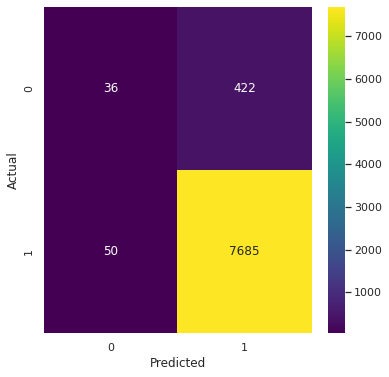

In [152]:
cm = confusion_matrix(y_test, y_knn_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='viridis', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Classification report

In [153]:
print(classification_report(y_test, y_knn_pred))

              precision    recall  f1-score   support

           0       0.42      0.08      0.13       458
           1       0.95      0.99      0.97      7735

    accuracy                           0.94      8193
   macro avg       0.68      0.54      0.55      8193
weighted avg       0.92      0.94      0.92      8193



#### 4.3. Support Vector Machine (SVM) <a name="heading--4-3"/>

In [154]:
cls = SVC()

cls.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [155]:
cls.score(X_train, y_train)

0.9414876302083334

In [156]:
# defining parameters
params = {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

svm = SVC(**params)  

In [157]:
# fitting the model
svm.fit(X_train, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [158]:
svm_train_score = svm.score(X_train, y_train)
svm_train_score

0.958984375

In [159]:
# predictions
y_svm_pred = svm.predict(X_test)
y_svm_pred

array([1, 1, 1, ..., 1, 1, 1])

In [160]:
svm_test_score = svm.score(X_test, y_test)
svm_test_score

0.9350665202001709

In [161]:
svm_roc_auc_score = roc_auc_score(y_test, y_svm_pred)
svm_accuracy_score = accuracy_score(y_test, y_svm_pred)
svm_f1_score = f1_score(y_test, y_svm_pred)


print('ROCAUC score:', svm_roc_auc_score)
print('Accuracy score:', svm_accuracy_score)
print('F1 score:', svm_f1_score)

ROCAUC score: 0.5640296898067255
Accuracy score: 0.9350665202001709
F1 score: 0.9661577608142493


Text(30.5, 0.5, 'Actual')

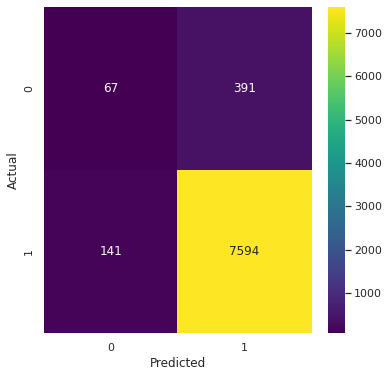

In [162]:
cm = confusion_matrix(y_test, y_svm_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='viridis', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [163]:
print(classification_report(y_test, y_svm_pred))

              precision    recall  f1-score   support

           0       0.32      0.15      0.20       458
           1       0.95      0.98      0.97      7735

    accuracy                           0.94      8193
   macro avg       0.64      0.56      0.58      8193
weighted avg       0.92      0.94      0.92      8193



#### 4.4. Logistic regression <a name="heading--4-4"/>

In [164]:
reg_log = LogisticRegression()

In [165]:
reg_log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [166]:
reg_log_train_score = reg_log.score(X_train, y_train)
reg_log_train_score

0.9414469401041666

In [167]:
y_log_pred = reg_log.predict(X_test)

In [168]:
reg_log_test_score = reg_log.score(X_test, y_test)
reg_log_test_score

0.9440986207738313

In [169]:
reg_log_roc_auc_score = roc_auc_score(y_test, y_log_pred)
reg_log_accuracy_score = accuracy_score(y_test, y_log_pred)
reg_log_f1_score = f1_score(y_test, y_log_pred)

print('ROCAUC score:', reg_log_roc_auc_score)
print('Accuracy score:', reg_log_accuracy_score)
print('F1 score:', reg_log_f1_score)

ROCAUC score: 0.5
Accuracy score: 0.9440986207738313
F1 score: 0.9712456052235058


Text(30.5, 0.5, 'Actual')

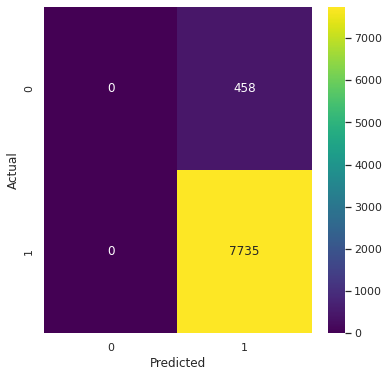

In [170]:
cm = confusion_matrix(y_test, y_log_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='viridis', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [171]:
print(classification_report(y_test, y_log_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       458
           1       0.94      1.00      0.97      7735

    accuracy                           0.94      8193
   macro avg       0.47      0.50      0.49      8193
weighted avg       0.89      0.94      0.92      8193



The logistic regression model could not deal with any target variable equals 0. This  model is only accurate at the values 1.

#### 4.5. Decision Tree <a name="heading--4-5"/>

In [172]:
dt = DecisionTreeClassifier(max_depth=1)

In [173]:
dt.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [174]:
dt.score(X_train, y_train)

0.9414469401041666

In [175]:
dtc = DecisionTreeClassifier()

In [176]:
params = {'max_depth': np.arange(1, 10),
         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

In [177]:
grid_search = GridSearchCV(dtc, param_grid=params, scoring='roc_auc', cv=5)


In [178]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
    

In [179]:
grid_search.best_params_

{'max_depth': 9, 'min_samples_leaf': 20}

In [180]:
grid_search_dtc = grid_search.best_estimator_
grid_search_dtc

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [181]:
dtc_train_score = grid_search_dtc.score(X_train, y_train)
dtc_train_score

0.943115234375

In [182]:
y_dtc_pred = grid_search_dtc.predict(X_test)
y_dtc_pred

array([1, 1, 1, ..., 1, 1, 1])

In [183]:
dtc_test_score = grid_search_dtc.score(X_test, y_test)
dtc_test_score

0.9439765653606738

In [184]:
dtc_roc_auc_score = roc_auc_score(y_test, y_dtc_pred)
dtc_accuracy_score = accuracy_score(y_test, y_dtc_pred)
dtc_f1_score = f1_score(y_test, y_dtc_pred)

print('ROCAUC score:', dtc_roc_auc_score)
print('Accuracy score:', dtc_accuracy_score)
print('F1 score:', dtc_f1_score)

ROCAUC score: 0.5379366459381871
Accuracy score: 0.9439765653606738
F1 score: 0.9710464896234151


Text(30.5, 0.5, 'Actual')

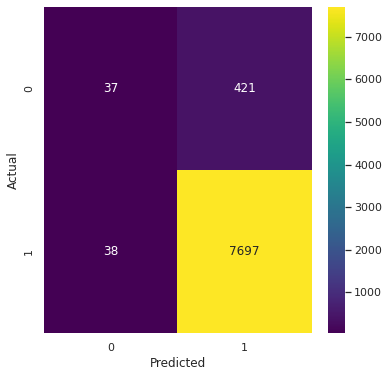

In [185]:
cm = confusion_matrix(y_test, y_dtc_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='viridis', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [186]:
print(classification_report(y_test, y_dtc_pred))

              precision    recall  f1-score   support

           0       0.49      0.08      0.14       458
           1       0.95      1.00      0.97      7735

    accuracy                           0.94      8193
   macro avg       0.72      0.54      0.55      8193
weighted avg       0.92      0.94      0.92      8193



#### 4.6. Random Forest <a name="heading--4-6"/>


In [187]:
rf = RandomForestClassifier()

param_grid = {
    'max_depth': np.arange(5, 16),
    'min_samples_leaf': [4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50]
}


In [188]:
grid_search_ = GridSearchCV(rf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv=5)


In [189]:
grid_search_.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [190]:
grid_search_.best_params_

{'max_depth': 15, 'min_samples_leaf': 6, 'n_estimators': 50}

In [191]:
grid_search_rf = grid_search_.best_estimator_
grid_search_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [192]:
rf_train_score = grid_search_rf.score(X_train, y_train)
rf_train_score

0.9465738932291666

In [193]:
y_rf_pred = grid_search_rf.predict(X_test)
y_rf_pred

array([1, 1, 1, ..., 1, 1, 1])

In [194]:
rf_test_score = grid_search_rf.score(X_test, y_test)
rf_test_score

0.9456853411448798

In [195]:
rf_roc_auc_score = roc_auc_score(y_test, y_rf_pred)
rf_accuracy_score = accuracy_score(y_test, y_rf_pred)
rf_f1_score = f1_score(y_test, y_rf_pred)

print('ROCAUC score:', rf_roc_auc_score)
print('Accuracy score:', rf_accuracy_score)
print('F1 score:', rf_f1_score)

ROCAUC score: 0.526516881525872
Accuracy score: 0.9456853411448798
F1 score: 0.9719967277075073


Text(30.5, 0.5, 'Actual')

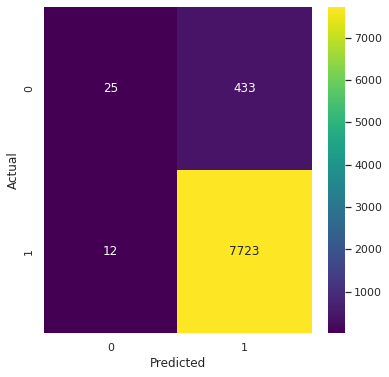

In [196]:
cm = confusion_matrix(y_test, y_rf_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='viridis', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [197]:
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

           0       0.68      0.05      0.10       458
           1       0.95      1.00      0.97      7735

    accuracy                           0.95      8193
   macro avg       0.81      0.53      0.54      8193
weighted avg       0.93      0.95      0.92      8193



#### 4.7. XGBoost classification <a name="heading--4-7"/>

In [198]:
xgb_class = xgb.XGBClassifier(colsample_bytree=0.4, gamma=0.05, 
                              learning_rate=0.1, max_depth=6, 
                              min_child_weight=3, n_estimators=2500)


In [199]:
xgb_class.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.05,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=None, n_estimators=2500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [200]:
xgb_train_score = xgb_class.score(X_train, y_train)
xgb_train_score

0.9855550130208334

In [201]:
y_xgb_pred = xgb_class.predict(X_test)

In [202]:
xgb_test_score = xgb_class.score(X_test, y_test)
xgb_test_score

0.9525204442817039

In [203]:
xgb_roc_auc_score = roc_auc_score(y_test, y_xgb_pred)
xgb_accuracy_score = accuracy_score(y_test, y_xgb_pred)
xgb_f1_score = f1_score(y_test, y_xgb_pred)

print('ROCAUC score:', xgb_roc_auc_score)
print('Accuracy score:', xgb_accuracy_score)
print('F1 score:', xgb_f1_score)

ROCAUC score: 0.6749525070357334
Accuracy score: 0.9525204442817039
F1 score: 0.9751675710181934


Text(30.5, 0.5, 'Actual')

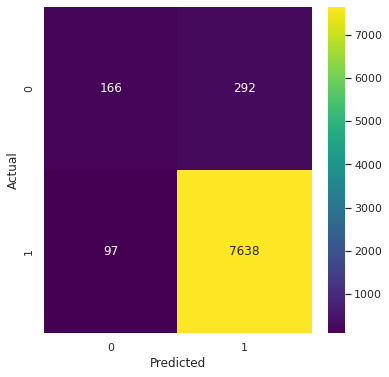

In [204]:
cm = confusion_matrix(y_test, y_xgb_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='viridis', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [205]:
print(classification_report(y_test, y_xgb_pred))

              precision    recall  f1-score   support

           0       0.63      0.36      0.46       458
           1       0.96      0.99      0.98      7735

    accuracy                           0.95      8193
   macro avg       0.80      0.67      0.72      8193
weighted avg       0.94      0.95      0.95      8193



#### 4.8. Comparison of results <a name="heading--4-8"/>

In [206]:
results = pd.DataFrame(columns=['Train_Accuracy_Score', 'Test_Accuracy_Score', 
                                'TEST_ROC_AUC_Score', 'Test_F1_Score'], 
                       index=['K-nearest Neighbour', 'Support Vector Machine', 
                              'Logistic Regression', 'Decision Tree', 
                              'Random Forest', 'XGBoost'])

results.loc['K-nearest Neighbour'] = [knn_train_score, knn_accuracy_score, 
                                      knn_roc_auc_score, knn_f1_score]

results.loc['Support Vector Machine'] = [svm_train_score, svm_accuracy_score, 
                                         svm_roc_auc_score, svm_f1_score]

results.loc['Logistic Regression'] = [reg_log_train_score, 
                                      reg_log_accuracy_score, 
                                      reg_log_roc_auc_score, reg_log_f1_score]

results.loc['Decision Tree'] = [dtc_train_score, dtc_accuracy_score, 
                                dtc_roc_auc_score, dtc_f1_score]

results.loc['Random Forest'] = [rf_train_score, rf_accuracy_score, 
                                rf_roc_auc_score, rf_f1_score]

results.loc['XGBoost'] = [xgb_train_score, xgb_accuracy_score, 
                          xgb_roc_auc_score, xgb_f1_score]


results.sort_values('Test_Accuracy_Score', ascending=False)

,Train_Accuracy_Score,Test_Accuracy_Score,TEST_ROC_AUC_Score,Test_F1_Score
XGBoost,0.985555,0.95252,0.674953,0.975168
Random Forest,0.946574,0.945685,0.526517,0.971997
Logistic Regression,0.941447,0.944099,0.5,0.971246
Decision Tree,0.943115,0.943977,0.537937,0.971046
K-nearest Neighbour,0.945068,0.94239,0.536069,0.970206
Support Vector Machine,0.958984,0.935067,0.56403,0.966158


In [207]:
# Predictions with XGBoost classification

y_pred = xgb_class.predict(test.values)
submission = pd.DataFrame({'Id': test_id, 'ACTION': y_pred})
submission.head()

,Id,ACTION
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [ ]:
# to submit the file on kaggle
# submission.to_csv('submission.csv', index=False, header=True)